# Alexander Muratov's Book Recommdner

I have often wondered why Goodreads, Amazon, and Audible just don't really do a good job in figuring out which books to recommend to me. Perhaps books are a little too personal and situational compared to movies and music. You invest much more time, and often can't boil down your review to just a number. How can you put a work of classic literature alongside a fun comic book? 

But I decided that I would give it a shot anyway. I decided to try the collaborative filtering algorithm I learned in Andrew Ng's coursera Machine Learning course on a public book rating dataset, and see what I get. Perhaps it would give me some cool ideas for what I should be reading, or at least help me see the challenges in solving this problem.


## Using data from  Book-Crossing Dataset 
http://www2.informatik.uni-freiburg.de/~cziegler/BX/

# Step 1. Data Cleaning 
Here, I am going to take the original raw data files and pull out only the information I need to build my recommender system.
The code presented here is a significantly streamlined version of the first time I actually tried to explore this data. 

In [15]:
import pandas as pd
import numpy as np

#first CSV file gives ratings for users for books by code number, but no titles
data = pd.read_csv("BookData_A/BX-Book-Ratings.csv", encoding='latin-1', sep=';')


In [16]:
#second CSV file gives book titles. Some of the titles have weird characters, so it must be read with latin-1 encoding
#This was a painful thing to figure out. 
bookdata = pd.read_csv("BookData_A/BX-Books.csv", encoding='latin-1', sep=';',error_bad_lines=False) 


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\Alejandro\Anaconda3\lib\site-packages\IPython\core\interactiveshe

In [17]:
#Merging the two CSV files to get a catalog with book titles and ratings 
catalog = data.merge(bookdata, on='ISBN', how='left')

#Getting rid of non-reviews - entries with a rating of 0
#also getting rid of book titles that are NULL value.
reduced_catalog = catalog[(catalog['Book-Rating']>0) & (catalog['Book-Title'].notnull())]


#check to make sure catalog looks ok
reduced_catalog.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...


In [18]:
mycounts = reduced_catalog["Book-Title"].value_counts()
mycounts.index[0:5]

Index(['The Lovely Bones: A Novel', 'Wild Animus', 'The Da Vinci Code',
       'The Secret Life of Bees', 'The Nanny Diaries: A Novel'],
      dtype='object')

In [19]:
#looks good. Now lets figure out which books are the ones that are reviewed most often to feed to the recommender system 

#lets start with a catalog of 1000 most reviewed books
num_top_books = 1000

countsorted_reviewed_books =  reduced_catalog["Book-Title"].value_counts()
most_reviewedbooks = countsorted_reviewed_books.index[0:num_top_books]
most_reviewed_bookcounts = countsorted_reviewed_books.values[0:num_top_books]
most_reviewedbooks[0:5]

Index(['The Lovely Bones: A Novel', 'Wild Animus', 'The Da Vinci Code',
       'The Secret Life of Bees', 'The Nanny Diaries: A Novel'],
      dtype='object')

In [20]:
most_reviewed_bookcounts[0:5]

array([707, 581, 494, 406, 393], dtype=int64)

In [21]:
#lets also make sure that the ones at the bottom of the list have enough reviews
most_reviewedbooks[-25:-1]

Index(['Man and Boy: A Novel',
       'Forever... : A Novel of Good and Evil, Love and Hope',
       'Rush Limbaugh Is a Big Fat Idiot: And Other Observations',
       'The Time Traveler's Wife (Today Show Book Club #15)', 'Anthem',
       'Reunion in Death', 'Revenge of the Middle-Aged Woman',
       'Princess: A True Story of Life Behind the Veil in Saudi Arabia',
       'Space',
       'The Claiming of Sleeping Beauty (Erotic Adventures of Sleeping Beauty)',
       'Fear and Loathing in Las Vegas : A Savage Journey to the Heart of the American Dream',
       'Lake Wobegon Days', 'Whisper of Evil (Hooper, Kay. Evil Trilogy.)',
       'The Tortilla Curtain', 'Ransom', 'Personal Injuries', 'My Antonia',
       'The Cat Who Brought Down the House', 'Snow Crash', 'Moment of Truth',
       'Bookends : A Novel', 'Russendisko.',
       'Uh-Oh: Some Observations from Both Sides of the Refrigerator Door',
       'If Looks Could Kill'],
      dtype='object')

In [22]:
most_reviewed_bookcounts[-15:-1]

array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36], dtype=int64)

In [23]:
#not bad. Seems like it will be a robust list
#because I am still not totally used to working with dataframes and my algorithm is designed for simple matrices and arrays
#I am going to start migrating some stuff to arrays now
titles = np.array( most_reviewedbooks)

#if someone wants to review the books themselves, uncomment to save text file
#np.savetxt("top_book_titles.txt",titles, fmt='%s')

In [24]:
#reducing the dataframe to only contain data for top X books

further_reduced_catalogCut = reduced_catalog["Book-Title"].isin(titles)
further_reduced_catalog = reduced_catalog[further_reduced_catalogCut]

In [25]:
#now lets get a set of the most active reviewers 

reviewingusers =  further_reduced_catalog["User-ID"].value_counts()

#i don't want any reviewers with fewer than 10 reviews.
top_users = reviewingusers[reviewingusers.values>10]
book_reviewers = np.array(top_users.index)
book_reviewers.shape

(1269,)

In [26]:
#I'm going to subddivide users into a test set and training set.
#as of now I am not actually doing this step, but if I wanted  to validate the recommender system,
#I would use only 70% of the data t otrain the model, and the other 30% to test. 
use_set = np.random.rand(top_users.shape[0]) > 0.7 
test_set = np.invert(use_set)


In [27]:
#so 1266 users for 1000 books. Seems like a reasonable final dataset.
#time to make final cuts on the catalog
final_further_reduced_catalogCut = further_reduced_catalog["User-ID"].isin(book_reviewers)
final_further_reduced_catalog = further_reduced_catalog[final_further_reduced_catalogCut]
final_further_reduced_catalog.head(5)



,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1456,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1474,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...,http://images.amazon.com/images/P/0061009059.0...
1522,277427,0316776963,8,Me Talk Pretty One Day,David Sedaris,2001,Back Bay Books,http://images.amazon.com/images/P/0316776963.0...,http://images.amazon.com/images/P/0316776963.0...,http://images.amazon.com/images/P/0316776963.0...
1543,277427,0345413903,10,The Murder Book,Jonathan Kellerman,2003,Ballantine Books,http://images.amazon.com/images/P/0345413903.0...,http://images.amazon.com/images/P/0345413903.0...,http://images.amazon.com/images/P/0345413903.0...
1578,277427,0385424736,9,The Rainmaker,John Grisham,1995,Doubleday Books,http://images.amazon.com/images/P/0385424736.0...,http://images.amazon.com/images/P/0385424736.0...,http://images.amazon.com/images/P/0385424736.0...


In [28]:
np.random.rand(1)[0]

0.019777016119494895

# Step 2. Setting up collaborative filtering
Here, I build a collaborative filtering recommendation system for the book reviews that is based on an assignment from the Stanford Machine Learning Coursera. In that case, prepared film data from IMDB was used. Interestingly, I tracked down several bugs and flaws in the code developed for the assignment and fixed them in this implementation. Will note when applicable.

In [29]:
#at this point, I am going to translate all the reviews in this catalog into a simple matrix containg reviews per user.
#i am going to use a simple numpy matrix since the remainder of my code is prepared for such a use.
# in the future, I will try to stick only  to Pandas framework
#titles = np.array(most_reviewedbooks["Book-Title"])
Y = np.zeros((len(titles), len(book_reviewers)))
print(Y.shape)
num_books = Y.shape[0]


(1000, 1269)


In [30]:
#now we go through the final catalog line by line and fill in the elements of Y.
#this is embarrasing and I'm sure there's a more efficient way to do this, but it's not too slow computationally for this dataset
count = 0
for row in final_further_reduced_catalog.values:
    title_index = np.where(titles==row[3])[0][0]
    user_index = np.where(book_reviewers==row[0])[0][0]   
    Y[title_index][user_index]=row[2]
    count+=1

Insert some additional user input. I personally went through the list of books and rated some.


In [31]:
#creating an extra column for the Y matrix 
my_ratings = np.zeros(num_books)
#opening text file. This text file has the 1000 most reviewed books. One book per row.
#For each book I rated, I assign a numerical score at the end of the line.
ratings_file = open('sasha_top_books.txt')
rating_lines = ratings_file.readlines()
index_ratings_ar = []
ratings_ar = []

#I will use regular expression to tease out the books that have been rated.
import re

for line in rating_lines:
    #look for all lines that end with a 1-2 digit number, and then a newline character
    rating = re.findall('\d+', line[-3:])
    if (len(rating)>0):
        rating_value = int(rating[0])
        
        #is the rating one or two characters?
        if (rating_value>=10):
            stripped_line = line[0:-3]
        else:
            stripped_line = line[0:-2]
        
        #now lets get rid of the rating and only keep the title
        extra_stripped_line = stripped_line.strip()
        
        #make sure this title matches one in our list. also find the index. 
        rating_index = np.where(titles==extra_stripped_line)
        if len(rating_index[0])>0:
            index_ratings_ar.append(rating_index[0][0])
            ratings_ar.append(rating_value)
            print ('I assigned this book: ', stripped_line,'\n This rating: ',rating_value)

#now assigning the reviews to our column vector
count = 0
while (count<len(index_ratings_ar)):
    my_ratings[index_ratings_ar[count]]=ratings_ar[count]
    count+=1
    
Y = np.column_stack((my_ratings,Y))


I assigned this book:  The Da Vinci Code              
 This rating:  1
I assigned this book:  The Nanny Diaries: A Novel        
 This rating:  1
I assigned this book:  Harry Potter and the Chamber of Secrets (Book 2)              
 This rating:  5
I assigned this book:  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))           
 This rating:  5
I assigned this book:  Angels &amp; Demons            
 This rating:  1
I assigned this book:  Harry Potter and the Prisoner of Azkaban (Book 3)              
 This rating:  5
I assigned this book:  Harry Potter and the Goblet of Fire (Book 4)               
 This rating:  5
I assigned this book:  Harry Potter and the Order of the Phoenix (Book 5)                
 This rating:  5
I assigned this book:  The Fellowship of the Ring (The Lord of the Rings, Part 1)              
 This rating:  8
I assigned this book:  The Golden Compass (His Dark Materials, Book 1)                      
 This rating:  8
I assigned this book:  Ameri

In [32]:
#the algorithm uses a second matrix R to tell if a given book has been reviewed by a given user
R = Y>0
num_users = Y.shape[1]
num_books = Y.shape[0]

In [33]:
#now setting some parameters for the collaborative filtering
#original Coursera version had 10 features, but I find better fits with 20. 
#lambda is the regularization parameter. 10 seems to work well
#prefactor is an extra weight for the random seed. 
prefactor = 1
my_lambda = 10.0
num_features = 20


In [34]:
#do-penalties - we don't want the recommender to get fooled by books that have a high mean score
#after it's been reviewed by only a single user. This is an element I added to the system to improve upon the quality of 
#recommendations given

do_penalties = True

In [35]:
#normalization function  that also returns mean score of each book and total number of reviews 
#for each book. 
#the algorithm works better when the scores are normalized (distance from mean)
def normalizeY(YM):
    cooper = np.copy(YM)
    themeans = []
    thecounts = []
    for arr in cooper:
        cut = arr>0
        themean = np.mean(arr[cut])
        count = len(arr[cut])
        themeans.append(themean)
        thecounts.append(float(count))
        arr[cut] = arr[cut] - themean
    themeans = np.array(themeans)
    thecounts = np.array(thecounts)
    return [cooper, themeans,thecounts]


In [36]:
#normalize the matrix, and find mean number of reviews per book
#books that have fewer reviews than the mean will have their score weighted 
#so that it des not deviate too far form a "neutral" review 

[normY, themeans,thecounts] = normalizeY(Y)
medcount = np.mean(thecounts)
print('mean count ',medcount)



mean count  28.633


In [37]:
#now we initialize matrices for books and users. Each element contains a score per feature.
#The features themselves are basically free variables that will be solved for by the optimizer
num_users = normY.shape[1]
print(num_books,num_users)
X= np.random.randn(num_books, num_features)*prefactor
Theta = np.random.randn(num_users, num_features)*prefactor

print(X.shape)
print(Theta.shape)

#unroll both matrices into a single array to be used by the optimizer
intial_parameters_unrolled  = np.append(np.array(X).reshape(-1), np.array(Theta).reshape(-1))

1000 1270
(1000, 20)
(1270, 20)


In [38]:
#now we define the cost function and the gradient of the cost function
#fully vectorized implementation
def cost_function_matrix_reshape_J(params, theY, theR, num_users, num_books, num_features, the_lambda):
    J = 0
    #unroll the vector back into two feture matrices
    X = params[0:(num_books*num_features)]
    X = X.reshape(num_books, num_features)
    Theta = params[(num_books*num_features):]
    Theta = Theta.reshape(num_users, num_features)

    #multiply the two feature matrices, and see how close they are to the target Y.
    #cost function is the difference of squares. Only considering books that have actual ratings in Y.
    J_sub1 = np.multiply((np.dot(X,Theta.transpose()) - theY), theR)
    J = np.sum(np.multiply(J_sub1,J_sub1)) / 2.0

    #add in regularization
    J +=  the_lambda*np.sum(np.multiply(X,X))/2.0  + the_lambda*np.sum(np.multiply(Theta,Theta))/2.0 
    print('current cost is ',J)

    return J

In [39]:
#fully vectorized implimentation of cost function gradient
def cost_function_matrix_reshape_grad(params, theY, R, num_users, num_books, num_features, the_lambda):

    #unroll the vector back into two feture matrices
    X = params[0:(num_books*num_features)]
    X = X.reshape(num_books, num_features)
    Theta = params[(num_books*num_features):]
    Theta = Theta.reshape(num_users, num_features)
    
    #similar calculation to computing J
    Grad_sub1 = np.dot(X,Theta.transpose())
    Grad_sub2 = np.multiply(Grad_sub1, R)
    Grad_sub3 = Grad_sub2 - theY
    
    #but now there's an extra step to compute the gradient by using the other feature matrix
    X_grad = np.dot(Grad_sub3, Theta)
    Theta_grad = np.dot(Grad_sub3.transpose(), X )
    
    #regularization step
    X_grad += the_lambda*X
    Theta_grad += the_lambda*Theta
    
    #return the results
    return np.append(X_grad.reshape(-1), Theta_grad.reshape(-1))

In [40]:
from scipy.optimize import fmin_cg

#now we run the optimizer fmin_cg to minimize the cost function.

results = fmin_cg(cost_function_matrix_reshape_J,intial_parameters_unrolled,fprime=cost_function_matrix_reshape_grad,\
                      args=(normY,R,num_users,num_books,num_features,my_lambda), maxiter=100,disp=True,full_output=True)

current cost is  563738.918594
current cost is  2.70390159853e+13
current cost is  18848584744.0
current cost is  8596300.30983
current cost is  241528.823506
current cost is  349721.461762
current cost is  158980.126026
current cost is  149436.114767
current cost is  130248.646001
current cost is  103840.21184
current cost is  98769.5305924
current cost is  119701.757049
current cost is  86272.6344527
current cost is  71709.5841097
current cost is  54053.3181025
current cost is  39828.5326925
current cost is  48088.8106938
current cost is  35365.1831347
current cost is  34995.2079221
current cost is  33362.4909984
current cost is  32430.4453175
current cost is  32015.6643582
current cost is  31400.5295403
current cost is  31125.218004
current cost is  31256.3039876
current cost is  30685.7928844
current cost is  30358.4970714
current cost is  30796.4342595
current cost is  30248.752044
current cost is  30087.2628949
current cost is  30041.767113
current cost is  29836.1264617
current 

# 3. Looking at the results

In [41]:
#unroll the results vector back into optimized feature matrices
returns = results[0]
newX = returns[:(num_books*num_features)]
newX = newX.reshape(num_books, num_features)
print(' my newX', newX.shape)
newTheta = returns[(num_books*num_features):]
newTheta = newTheta.reshape(num_users, num_features)
print( 'my newTheta ',newTheta.shape)
p = np.dot(newX,  newTheta.transpose())

 my newX (1000, 20)
my newTheta  (1270, 20)


In [42]:
#add the means back in
my_predictions = p[:,0] + themeans
#this is where i penalize scores of books that have fewer than the mean number of reviews
cut = (thecounts<medcount)

# i set it up such that if the book has no reviews, it is assigned a score of 5
# if the book has more than the mean number of reviews, it is assigned whatever actual scores it got.
# if a book has in between zero and n_mean reviews, it is given a linear combination of  5 and the predicted
# score based on the distance to each
if (do_penalties):
    my_predictions[cut] = ((medcount-thecounts[cut])/medcount) * 5.0 + (thecounts[cut]/medcount)*my_predictions[cut]

In [43]:
#print top 20 best rated book.
fingers = np.argsort(-1*my_predictions)
print("Top 20 books to read")

for i in range(0, 20):
    print ('Book to read: ',titles[fingers][i], '\n Predicted score: ', my_predictions[fingers][i])

Top 20 books to read
Book to read:  A Prayer for Owen Meany 
 Predicted score:  9.86794521763
Book to read:  The Two Towers (The Lord of the Rings, Part 2) 
 Predicted score:  9.5238345957
Book to read:  The Return of the King (The Lord of the Rings, Part 3) 
 Predicted score:  9.31760339969
Book to read:  The Amber Spyglass (His Dark Materials, Book 3) 
 Predicted score:  9.18383969247
Book to read:  The Murder Book 
 Predicted score:  9.07968606805
Book to read:  To Kill a Mockingbird 
 Predicted score:  9.05206777486
Book to read:  Griffin &amp; Sabine: An Extraordinary Correspondence 
 Predicted score:  9.03747667456
Book to read:  The Secret Garden 
 Predicted score:  9.00014751845
Book to read:  Slaughterhouse Five or the Children's Crusade: A Duty Dance With Death 
 Predicted score:  8.92457439239
Book to read:  The Stand: Complete and Uncut 
 Predicted score:  8.89811728547
Book to read:  Gone with the Wind 
 Predicted score:  8.86537399422
Book to read:  The Little Prince 
 Pr

In [44]:
fingers = np.argsort(my_predictions)
print("As a bonus, here are some books you shouldn't bother reading")
for i in range(0, 20):
    print ('Book not to read: ',titles[fingers][i], '\n Predicted score: ', my_predictions[fingers][i])

As a bonus, here are some books you shouldn't bother reading
Book not to read:  The Da Vinci Code 
 Predicted score:  2.70306184654
Book not to read:  The Nanny Diaries: A Novel 
 Predicted score:  2.82603590119
Book not to read:  Angels &amp; Demons 
 Predicted score:  3.45291808629
Book not to read:  Four Blondes 
 Predicted score:  4.45014251078
Book not to read:  The Pilot's Wife : A Novel 
 Predicted score:  4.73676567614
Book not to read:  The Bourne Identity 
 Predicted score:  4.75114716448
Book not to read:  Deception Point 
 Predicted score:  4.85121845473
Book not to read:  The Little Friend 
 Predicted score:  4.9390474457
Book not to read:  Russendisko. 
 Predicted score:  5.06984446429
Book not to read:  Free 
 Predicted score:  5.10476968724
Book not to read:  The Celestine Prophecy 
 Predicted score:  5.12055488448
Book not to read:  The Angel of Darkness 
 Predicted score:  5.22785675743
Book not to read:  Stupid White Men. Eine Abrechnung mit dem Amerika unter George 

Overall, I am pleased that this algorithm works. It (correctly) recommends books that I have already read and rated highly. If I really only wanted new books to read, I would obviously filter those out, but I kept them in as a sanity check. It recommends more Lord of the Rings book after I said I liked the first one. It also recommends the final His Dark Materials book, after I rated the first two pretty highly.

On the other hand, the level of customization is not exactly top-notch.  I have tried it with various inputs, and it tends to always recommend a few specific titles. A Prayer for Owen Meany, Griffin & Sabine, Anne of Green Gables, and The Secret Garden are favorites. I suspect this sort of collaborative filtering is prone to function in this way. Most people only finish reading something that they are already invested in, and would rate highly. I think it's different than the small amount of investment that people would put in for a movie review. For a second pass at this problem, I would probably try association algorithms using decision trees instead of collaborative filtering. 

Nonetheless, there are probably a few solid recommendations in this list. I am actually pretty intrigued by Griffin & Sabine. This was a fun project! 

   # 4. Evaluating the effectiveness of the project!

Lets put some more work into this now! I think we can do some interesting things with the data. My first thought on how this should be done is to withhold about 10% of the data from the algorithm, and see how effectively it captures it. 


In [809]:
trainY = np.zeros((len(titles), len(book_reviewers)))
print(trainY.shape)

(1000, 1269)


In [810]:
number_of_entries = len(final_further_reduced_catalog)


#opening up parameters for exploration
num_features = 20 
my_lambda = 10

In [811]:
train_or_test = np.random.rand(number_of_entries)


For each entry in the final catalog, I generated a random number from 0 to 1. this will be used to determine whether something goes into the training or test set. I create the target review matrix with 90% of the data, and hide the remaining 10% from the algorithm, but store it in a set of arrays for later use. 

In [812]:
count = 0

test_title_indeces = []
test_user_indeces = []
test_scores = []

for row in final_further_reduced_catalog.values:
    title_index = np.where(titles==row[3])[0][0]
    user_index = np.where(book_reviewers==row[0])[0][0]   
    if (train_or_test[count]< 0.9):
        trainY[title_index][user_index]=row[2]
    else:
        test_title_indeces.append(title_index)
        test_user_indeces.append(user_index)
        #have to save the indices so that we know where to look later.
        test_scores.append(row[2])
    count+=1


In [813]:
#checking the number of entries that will be used to test the algorithm. 
num_test_scores = len(test_scores)

len(test_scores)


2889

In [814]:
#repeating procedure from before. Using a new set of data structures
trainR = trainY>0
train_num_users = trainY.shape[1]
train_num_books = trainY.shape[0]

In [815]:
# mean for number of reviews is about the same as before. 
[train_normY, train_themeans,train_thecounts] = normalizeY(trainY)
train_medcount = np.mean(train_thecounts)
print('mean count ',train_medcount)

mean count  25.804


In [816]:

trainX= np.random.randn(train_num_books, num_features)*prefactor
trainTheta = np.random.randn(train_num_users, num_features)*prefactor

print(trainX.shape)
print(trainTheta.shape)

#unroll both matrices into a single array to be used by the optimizer
intial_parameters_unrolled  = np.append(np.array(trainX).reshape(-1), np.array(trainTheta).reshape(-1))

(1000, 20)
(1269, 20)


In [817]:
#train the results
train_results = fmin_cg(cost_function_matrix_reshape_J,intial_parameters_unrolled,fprime=cost_function_matrix_reshape_grad,\
                      args=(train_normY,trainR,train_num_users,train_num_books,num_features,my_lambda), maxiter=100,disp=True,full_output=True)

current cost is  529759.383644
current cost is  1.46407195672e+13
current cost is  9995028967.95
current cost is  4157682.17628
current cost is  228133.957013
current cost is  347596.934925
current cost is  153825.938548
current cost is  132297.011468
current cost is  94030.7553771
current cost is  138254.22477
current cost is  81373.8108041
current cost is  92771.8552859
current cost is  60770.2773328
current cost is  61223.0791978
current cost is  55300.7249178
current cost is  46053.7419266
current cost is  39061.0270569
current cost is  44344.569975
current cost is  33840.9871914
current cost is  30953.6468387
current cost is  30377.3189457
current cost is  30804.3938371
current cost is  29075.6132975
current cost is  29186.4852455
current cost is  28424.4726788
current cost is  28150.1267079
current cost is  28000.9094503
current cost is  27759.0712467
current cost is  27700.6853219
current cost is  27510.1562347
current cost is  27475.4488471
current cost is  27323.6829418
curren

In [818]:
#unroll results
train_returns = train_results[0]
train_newX = train_returns[:(train_num_books*num_features)]
train_newX = train_newX.reshape(train_num_books, num_features)
print(' my train_newX', train_newX.shape)
train_newTheta = train_returns[(train_num_books*num_features):]
train_newTheta = train_newTheta.reshape(train_num_users, num_features)
print( 'my train_newTheta ',train_newTheta.shape)
train_p = np.dot(train_newX,  train_newTheta.transpose())
train_p.shape

 my train_newX (1000, 20)
my train_newTheta  (1269, 20)


(1000, 1269)

Now, to evaluate how well the algorithm did compared to a "null method" - assigning the mean score to every user. Since we don't really care about minor nudges in either direction, how about checking for shifts greater than 1 point on the 10 point scale. We count up how many times the algorithm predicted scores was closer to the actual score than the mean score would've been. "Good Scores" represent times when the algorithm did a beter job. "Bad Scores" When we may as well have just used the mean score for the book.

In [819]:
#how accurate was the matrix that was trained with 90% of the data at guessing the remaining 10%? 
good_count = 0
bad_count = 0
for i in range(0,num_test_scores):
    #trained_score = train_p[test_title_indeces[i],test_user_indeces[i]] + themeans[test_title_indeces[i]]
    trained_adjustment = train_p[test_title_indeces[i],test_user_indeces[i]]
    mean_for_book =  train_themeans[test_title_indeces[i]]
    trained_score = trained_adjustment+mean_for_book
    if (abs(trained_adjustment) > 1): 
        #print("entry ", i,": the real score was ", test_scores[i]," trained score ",trained_score)
        #print("mean was ", mean_for_book," adjustment ",trained_adjustment)
        distance = abs( test_scores[i] - trained_score)
        dist_to_mean = abs(test_scores[i] -mean_for_book )
        if (distance < dist_to_mean):
            good_count+=1
        else:
            bad_count+=1
        


In [820]:
good_count

145

In [821]:
bad_count

44

In [822]:
fraction_of_good_adjustments = (good_count)/(good_count+bad_count)

In [823]:
fraction_of_good_adjustments

0.7671957671957672

Hey not bad! My algorithm does better than the mean score more than 70% of the time! That is actually better than I was expecting. Not amazing but it is pretty good. 

I have tried playing with some of the parameters for the fitting - namely num_features and my_lambda to see if i can do better.

High values of my_lambda (20 or more) can actually improve performance above 80%, but in exchange for making significantly fewer recommendations (good_count < 50). 

Low values of  my_lambda (5 or less) weakens the algorithm a lot too (about 50%). Same with num_features (3 or less) 

high values of num_features (100) appear to improve performacne slightly, but not significantly enough to convince me it matters too much, and the cost of computation becomes higher. 




One last check. Lets see how this same test works if the algorithm is trained with 100% of the same data. 

In [824]:
#using matrix that was actually trained with 100% of the data. 
good_count = 0
bad_count = 0
for i in range(0,num_test_scores):
    #trained_score = train_p[test_title_indeces[i],test_user_indeces[i]] + themeans[test_title_indeces[i]]
    trained_adjustment = p[test_title_indeces[i],test_user_indeces[i]+1]
    mean_for_book =  train_themeans[test_title_indeces[i]]
    trained_score = trained_adjustment+mean_for_book
    if (abs(trained_adjustment) > 1): 
        #print("entry ", i,": the real score was ", test_scores[i]," trained score ",trained_score)
        #print("mean was ", mean_for_book," adjustment ",trained_adjustment)
        distance = abs( test_scores[i] - trained_score)
        dist_to_mean = abs(test_scores[i] -mean_for_book )
        if (distance < dist_to_mean):
            good_count+=1
        else:
            bad_count+=1

In [825]:
fraction_of_good_adjustments = (good_count)/(good_count+bad_count)

In [826]:
fraction_of_good_adjustments

0.9816700610997964

Well hey it works really well! I guess this goes to show that this methodology really does fit the data quite well. Sadly, the predictive power is significantly diminished if we hide even 10% of the data away from it. 

# Visualizing The Data

The product of the recommender system is recommendations. Visualizing this data isn't exactly the most exciting thing. However, we can look at the intermediate product - the features that the algorithm decided to segregate books and users by. 

First, let's take a look at the top 10 most read books, and see what their feature space looks like

In [835]:
ReducedX = newX[0:10]
ReducedX.shape

(10, 20)

In [847]:
titles[0:10]

array(['The Lovely Bones: A Novel', 'Wild Animus', 'The Da Vinci Code',
       'The Secret Life of Bees', 'The Nanny Diaries: A Novel',
       'The Red Tent (Bestselling Backlist)', "Bridget Jones's Diary",
       'A Painted House', 'Life of Pi',
       'Harry Potter and the Chamber of Secrets (Book 2)'], dtype=object)

In [836]:
%matplotlib inline
import matplotlib.pyplot as plt


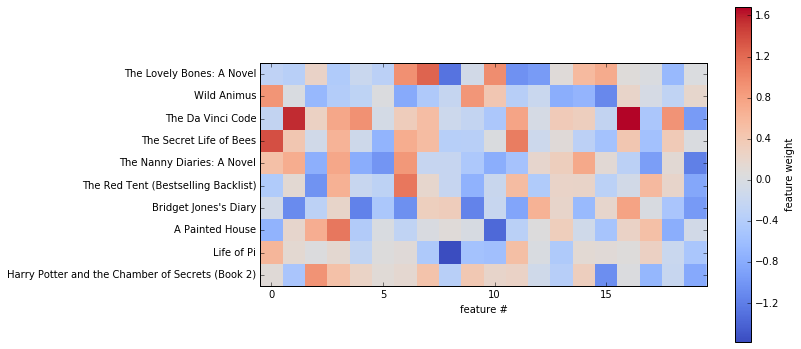

In [904]:
fig1 = plt.figure(figsize=(10,6))
fig1a = plt.imshow(ReducedX, cmap=plt.cm.coolwarm, interpolation='none')
plt.xlabel('feature #')
#plt.ylabel("book")
bookpos = np.arange(10)
plt.yticks(bookpos, titles[0:10])
plt.colorbar(fig1a, label='feature weight')


Pretty interesting. The top 10 books all look pretty different in feature space fo the most part. There do appear to be some features which the top books seem to have predominantly positive or negative entries in. It is pretty hard to interpret the meaning of the features. For example, Da Vinci code has very high values for features #1 and #16. Bridget jones diary also has a high value in #16 and a particularly low value in #1. What does this mean? Who knows, it's hard to find a thematic pattern in the features. I was hoping it could be straightfowardly thematic elements like "Fantasy" or "History" but the reality is much less clear and more complicated. 

OK but to be fair, I haven't read any of those books except Harry Potter. Lets see what a set of books that I actually like have more information in their features.

In [907]:
my_fav_books = my_ratings > 7

In [909]:
favX  = X[my_fav_books]

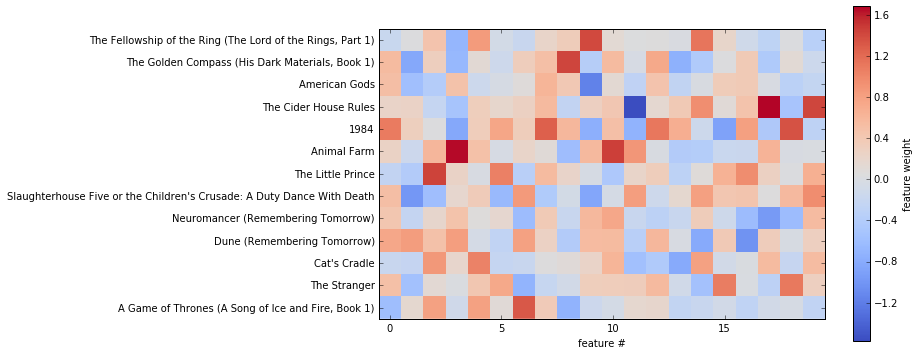

In [912]:
fig2 = plt.figure(figsize=(10,6))
fig2a = plt.imshow(favX, cmap=plt.cm.coolwarm, interpolation='none')
plt.xlabel('feature #')
#plt.ylabel("book")
bookpos = np.arange(13)
plt.yticks(bookpos, titles[my_fav_books])
plt.colorbar(fig1a, label='feature weight')

Still hard to see patterns here. Books by the same author like Kurt Vonnegut's Cat's Cradle and Slaughterhouse Five don't really seem to correlate with each other much in terms of features. Same with George Orwell's 1984 and Animal Farm At least it's hard to see visually. Maybe 20 features is too many to see patterns easily. 

What about a pattern in my top unique recommendations from the algorithm? 

In [913]:
my_top_picks =  p[:,0]

In [914]:
pickorder = np.argsort(-my_top_picks)

In [916]:
recX = X[pickorder]
reduced_recX = recX[0:10]

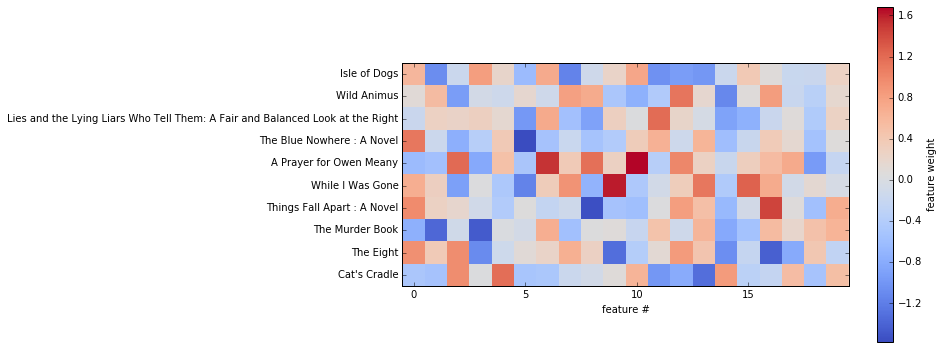

In [917]:
fig3 = plt.figure(figsize=(10,6))
fig3a = plt.imshow(reduced_recX, cmap=plt.cm.coolwarm, interpolation='none')
plt.xlabel('feature #')
#plt.ylabel("book")
bookpos = np.arange(10)
plt.yticks(bookpos, titles[pickorder][0:10])
plt.colorbar(fig1a, label='feature weight')

Maybe there's a pattern in here somewhere, but I still can't really see it. 

One last check, let me plot the features that the algorithm assigned to me as a user, and see how it looks compared to each of these titles. 

In [924]:
my_features = newTheta[0]
my_features

array([ 0.03090376, -0.53602673, -0.48591556, -1.04667394, -0.12477943,
        0.46179444, -0.79049556, -0.09169746,  0.36397895,  0.22717406,
        0.51502691, -0.02413212, -0.21085675, -0.20451521, -0.60992359,
        0.60958186, -0.92578211,  0.90707922,  0.07048949,  0.93125688])

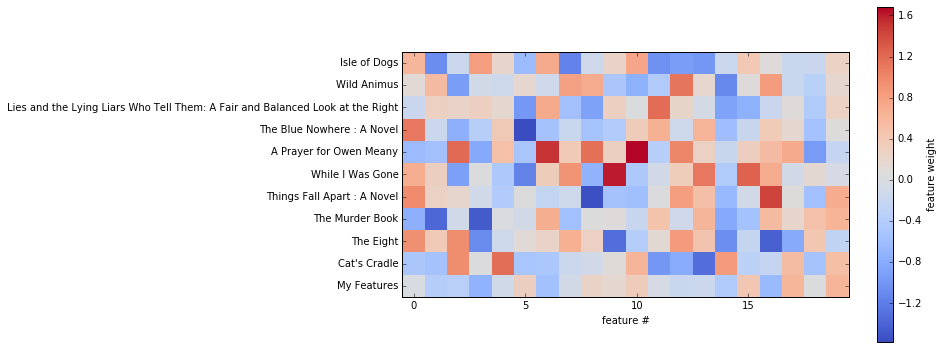

In [934]:
fig3 = plt.figure(figsize=(10,6))
fig3a = plt.imshow(np.vstack([reduced_recX,my_features]), cmap=plt.cm.coolwarm, interpolation='none')
plt.xlabel('feature #')
#plt.ylabel("book")
bookpos = np.arange(11)
plt.yticks(bookpos, np.append(titles[pickorder][0:10],["My Features"]))
plt.colorbar(fig1a, label='feature weight')

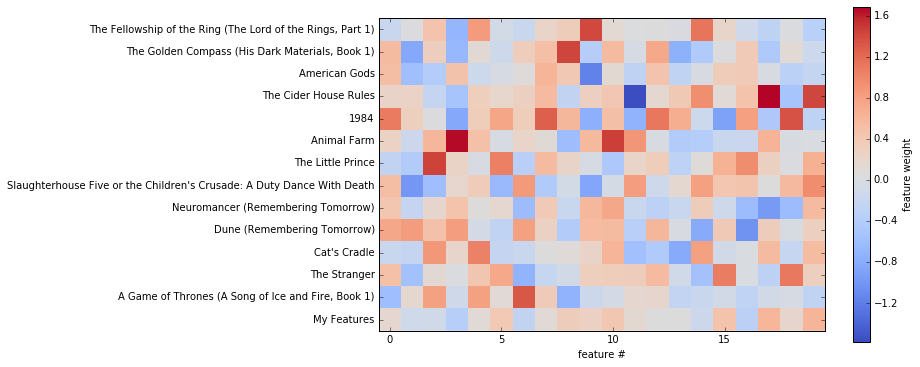

In [933]:
fig2 = plt.figure(figsize=(10,6))
fig2a = plt.imshow(np.vstack([favX,my_features]), cmap=plt.cm.coolwarm, interpolation='none')
plt.xlabel('feature #')
#plt.ylabel("book")
bookpos = np.arange(14)
plt.yticks(bookpos, np.append(titles[my_fav_books],["My Features"]))
plt.colorbar(fig1a, label='feature weight')

It is still very difficult to see patterns in these features! I guess this tells me that the features that the computer picks out cannot be thought of as "categories" in the traditional sense. 

For whatever reason, the data provided by the reviewing users doesn't lend itself to grouping books by content-based categories. 

Collaborative filtering is specifically designed to optimize parameters to fit numerical ratings. It couldn't care less what we humans think the book belongs in. 

In this way it is a more "pure" algorithm than content-based filtering or association. 